In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)

alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


In [6]:
# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[13]

print(dat.keys())
print("Number of neurons: {}\nNumber of trials: {}\nNumber of timesteps: {}".format(*dat['spks'].shape))
print("Recorded brain areas:", *["{} ({}),".format(*elem) for elem in zip(*np.unique(dat['brain_area'], return_counts=True))])


dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])
Number of neurons: 756
Number of trials: 268
Number of timesteps: 250
Recorded brain areas: CA1 (99), MOs (186), MRN (72), ORB (170), PAG (14), RSP (85), SCm (48), SCs (37), VISp (42), root (3),


### Mean firing rate

In [13]:

def get_trials_by_outcome(dat, min_contrast_diff=1., rdm_equalize=False):
    # TODO: must be different
    keep_trials = np.logical_or(
        np.logical_and(dat['contrast_left'] != dat['contrast_right'],
                       np.abs(dat['contrast_left'] - dat['contrast_right']) <= min_contrast_diff),
        dat['contrast_left'] == 0)
    feedback_type = dat['feedback_type']
    
    reward_trials = np.logical_and(keep_trials, feedback_type == 1)
    penalty_trials = np.logical_and(keep_trials, feedback_type == -1)
    
    return reward_trials, penalty_trials



def plot_mean_spks(brain_area):
    spks = dat['spks'][dat['brain_area'] == brain_area]

    reward_trials, penalty_trials = get_trials_by_outcome(dat)
    
    spks_reward = spks[:,reward_trials]
    spks_penalty = spks[:,penalty_trials]
    
    mean_spks_reward = spks_reward.mean(axis=(0,1))
    mean_spks_penalty = spks_penalty.mean(axis=(0,1))

    dt = 0.01 # bin duration (ms)
    t = np.arange(len(mean_spks_reward))*dt
    t -= 0.5 # set timestep 0 to stimulus onset 

    plt.plot(t, mean_spks_reward, label="Reward")
    plt.plot(t, mean_spks_penalty, label="Penalty")

In [14]:
reward_trials, penalty_trials = get_trials_by_outcome(dat, min_contrast_diff=1)
print("Min contrast difference:", 1)
print("Number of reward trials:", np.count_nonzero(reward_trials))
print("Number of penalty trials:", np.count_nonzero(penalty_trials))
print()

reward_trials, penalty_trials = get_trials_by_outcome(dat, min_contrast_diff=0.75)
print("Min contrast difference:", 0.75)
print("Number of reward trials:", np.count_nonzero(reward_trials))
print("Number of penalty trials:", np.count_nonzero(penalty_trials))
print()

reward_trials, penalty_trials = get_trials_by_outcome(dat, min_contrast_diff=0.5)
print("Min contrast difference:", 0.5)
print("Number of reward trials:", np.count_nonzero(reward_trials))
print("Number of penalty trials:", np.count_nonzero(penalty_trials))
print()

reward_trials, penalty_trials = get_trials_by_outcome(dat, min_contrast_diff=0.25)
print("Min contrast difference:", 0.25)
print("Number of reward trials:", np.count_nonzero(reward_trials))
print("Number of penalty trials:", np.count_nonzero(penalty_trials))

Min contrast difference: 1
Number of reward trials: 181
Number of penalty trials: 75

Min contrast difference: 0.75
Number of reward trials: 165
Number of penalty trials: 72

Min contrast difference: 0.5
Number of reward trials: 136
Number of penalty trials: 58

Min contrast difference: 0.25
Number of reward trials: 109
Number of penalty trials: 50


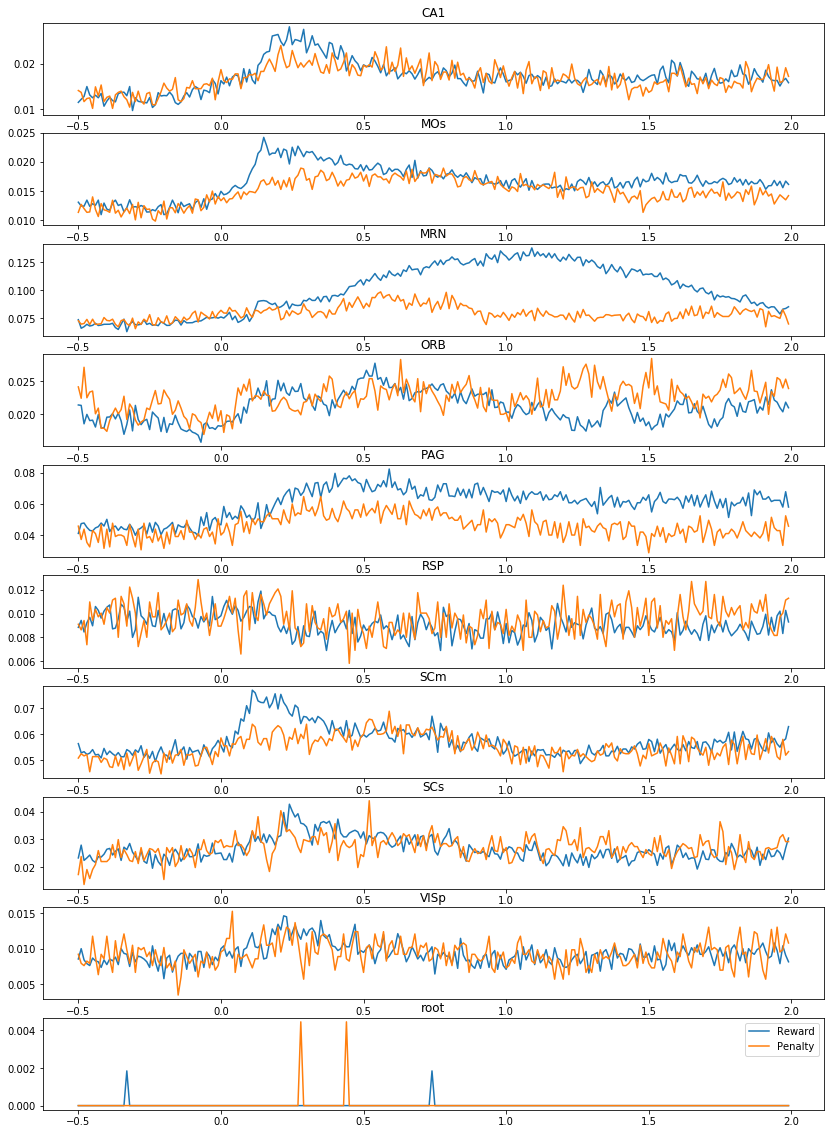

In [15]:
plt.figure(figsize=[14, 20])

brain_areas = np.unique(dat['brain_area'])
for i, brain_area in enumerate(brain_areas):
    plt.subplot(len(brain_areas), 1, i+1)
    plot_mean_spks(brain_area)
    plt.title(brain_area)
plt.legend()
plt.show()

The white noise mean spiking seems to oscillate more but might be due to less white noise trials than for the reward trials. 
* Take a random subset to have the same number ?
* Select only difficult trials to have more or less the same number ?

### Pupil area

(250,)


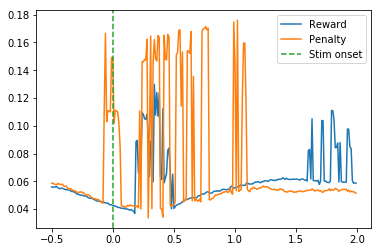

In [16]:
reward_trials, penalty_trials = get_trials_by_outcome(dat)
pupil_reward = dat['pupil'][0,reward_trials].mean(axis=0)
pupil_penalty = dat['pupil'][0,penalty_trials].mean(axis=0)

print(pupil_reward.shape)

dt = 0.01 # bin duration (ms)
t = np.arange(len(pupil_reward))*dt
t -= 0.5 # set timestep 0 to stimulus onset

plt.plot(t, pupil_reward, label="Reward")
plt.plot(t, pupil_penalty, label="Penalty")
plt.axvline(0, color="tab:green", linestyle="--", label="Stim onset")
plt.legend()
plt.show()

(690476,)


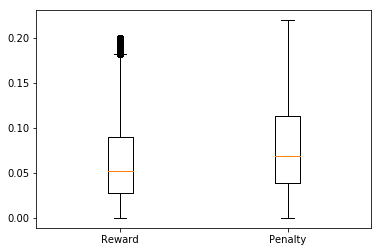

0.06428263017042887 0.07978205679252671


In [85]:
# 0.5s pre-stimulus

rew = np.array([])
pen = np.array([])

for session_dat in alldat:
    reward_trials, penalty_trials = get_trials_by_outcome(session_dat)
#     prestim_pupil_reward = session_dat['pupil'][0,reward_trials][:,0:50]
#     prestim_pupil_penalty = session_dat['pupil'][0,penalty_trials][:,0:50]

    prestim_pupil_reward = session_dat['pupil'][0,session_dat['response'] == 0]
    prestim_pupil_penalty = session_dat['pupil'][0,session_dat['response'] != 0]

    
    prestim_pupil_penalty = prestim_pupil_penalty[np.logical_and(prestim_pupil_penalty>0,
                                                                 prestim_pupil_penalty<0.5)]
    
    prestim_pupil_reward = prestim_pupil_reward[np.logical_and(prestim_pupil_reward>0,
                                                                 prestim_pupil_reward<0.5)]
    
    
    rew = np.concatenate((rew, prestim_pupil_reward.reshape(-1)))
    pen = np.concatenate((pen, prestim_pupil_penalty.reshape(-1)))
    

rew = rew[rew < rew.mean()+2*rew.std()]
pen = pen[pen < pen.mean()+2*pen.std()]

print(rew.shape)
plt.boxplot([rew, pen], labels=["Reward", "Penalty"])
# print(prestim_avg_pupil_reward.mean(), prestim_avg_pupil_penalty.mean())
plt.show()
print(rew.mean(), pen.mean())

Pupil area measure of arousal but not of performance ?

Condition on engagement instead of task performance ?

## PCA pre-stimulus neural activity

https://pietromarchesi.net/pca-neural-data.html

In [10]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

keep_trials = np.logical_or(dat['contrast_left'] != dat['contrast_right'],
                                             dat['contrast_left'] == 0)

def time_avg_pca(brain_area, n_components=2):
    if brain_area not in dat['brain_area']:
        print("Brain area not recorded !")
    spks = dat['spks'][dat['brain_area'] == brain_area,:,0:50]

    spks = spks[:,keep_trials]
    
    # average along the time axis
    mean_spks= spks.mean(axis=-1)
    X = mean_spks.reshape(mean_spks.shape[0], -1).T # n_samples x n_features
 
    # substract the mean
    X = X - X.mean(axis=0)

    pca = PCA(n_components=n_components)
    proj_X = pca.fit_transform(X)

#     print("Explained variance ratio:", pca.explained_variance_ratio_)
#     print(proj_X.shape)
    return proj_X, pca.explained_variance_ratio_


def moving_average(signal, n=3) :
    ret = np.cumsum(signal, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def z_score(X, normalize=False):
    # X: ndarray, shape (n_samples, n_features)
    ss = StandardScaler(with_mean=True, with_std=normalize)
    Xz = ss.fit_transform(X)
    return Xz

def outcome_avg_pca(brain_area, n_components=2, moving_avg_window=5, normalize=False, n_timesteps=250):
    if brain_area not in dat['brain_area']:
        print("Brain area not recorded !")
    spks = dat['spks'][dat['brain_area'] == brain_area]
    
    spks = spks[:,:,:n_timesteps]
    
    reward_trials, penalty_trials = get_trials_by_outcome(dat)
        
    penalty_spks = spks[:,penalty_trials].mean(axis=1)
    
    # TODO: equalize reward and penalty trials !
#     reward_spks = spks[:,reward_trials][:,np.count_nonzero(penalty_trials):]
    reward_spks = spks[:,reward_trials].mean(axis=1) # n_neurons x n_timesteps
    
    
    # temporal smoothing
    for i in range(len(reward_spks)):
        reward_spks[i,(moving_avg_window-1):] = moving_average(reward_spks[i], n=moving_avg_window)
        penalty_spks[i,(moving_avg_window-1):] = moving_average(penalty_spks[i], n=moving_avg_window)
    
    # 2*n_timesteps vectors of dimension n_neurons
    X = np.hstack((reward_spks, penalty_spks)) # n_neurons x 2*n_timesteps
    X = X.T# n_samples = 2*n_timesteps x n_features = n_neurons
    
#     # substract the mean firing rate for each neuron
#     X = X - X.mean(axis=0)

    X = z_score(X, normalize)

    pca = PCA(n_components=n_components)
    # 2*n_timesteps vectors of dimension n_components
    pca.fit(X)
   
    proj_X = pca.transform(X)
    return proj_X, pca.explained_variance_ratio_



**Some brain area doesn't contain a lot of neurons !** e.g. PAG: 14 neurons

Explained var for  CA1 : [0.6346714  0.12713494]
Explained var for  MOs : [0.4729349  0.17278926]
Explained var for  MRN : [0.81601572 0.07689454]
Explained var for  ORB : [0.45960674 0.10471716]
Explained var for  PAG : [0.54795443 0.21920265]
Explained var for  RSP : [0.24422519 0.11889134]
Explained var for  SCm : [0.51269803 0.17217349]
Explained var for  SCs : [0.36473558 0.16491315]
Explained var for  VISp : [0.42988875 0.10013832]


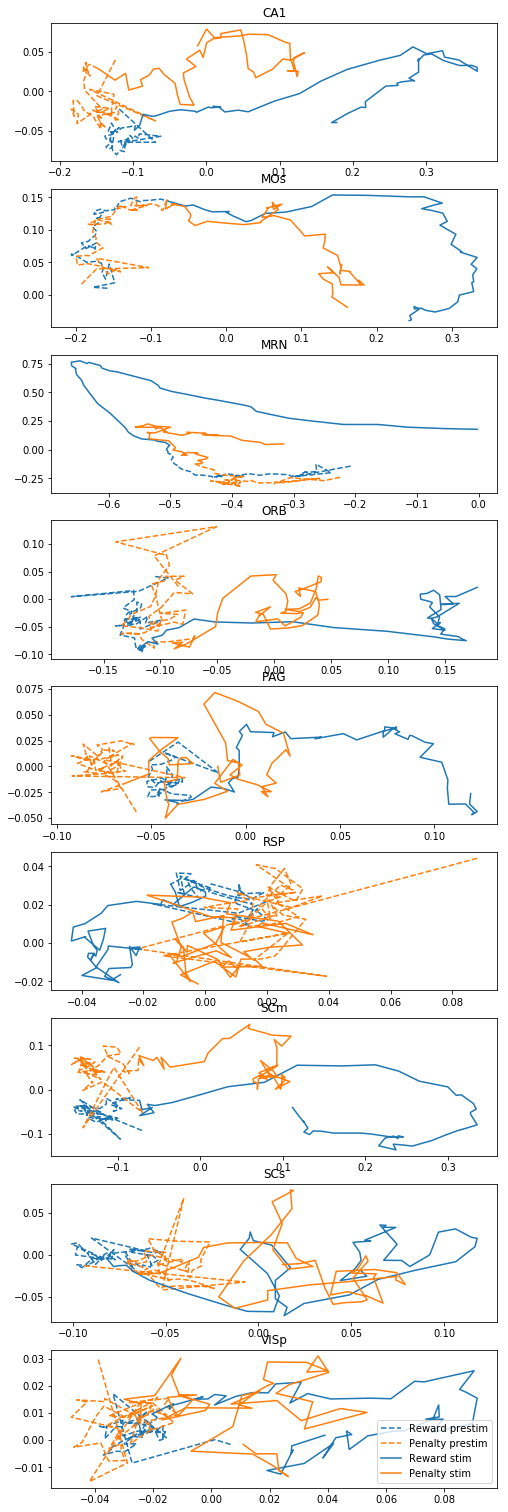

In [87]:
plt.figure(figsize=[8, 30])

# plot the two first principal components
brain_areas = np.unique(dat['brain_area'])
for i, brain_area in enumerate(brain_areas[:-1]):
    proj_data, explained_var = outcome_avg_pca(brain_area, moving_avg_window=5)
    print("Explained var for ", brain_area, ":", explained_var)

    reward_mean_trial = proj_data[:250]
    penalty_mean_trial = proj_data[250:]

    plt.subplot(len(brain_areas), 1, i+1)
    plt.plot(reward_mean_trial[:50,0], reward_mean_trial[:50,1], label="Reward prestim", linestyle="--")
    plt.plot(penalty_mean_trial[:50,0], penalty_mean_trial[:50,1], label="Penalty prestim", linestyle="--")
    
    plt.plot(reward_mean_trial[49:100,0], reward_mean_trial[49:100,1], color="tab:blue", label="Reward stim")
    plt.plot(penalty_mean_trial[49:100,0], penalty_mean_trial[49:100,1], color="tab:orange", label="Penalty stim")
    
    plt.title(brain_area)
plt.legend()
plt.show()



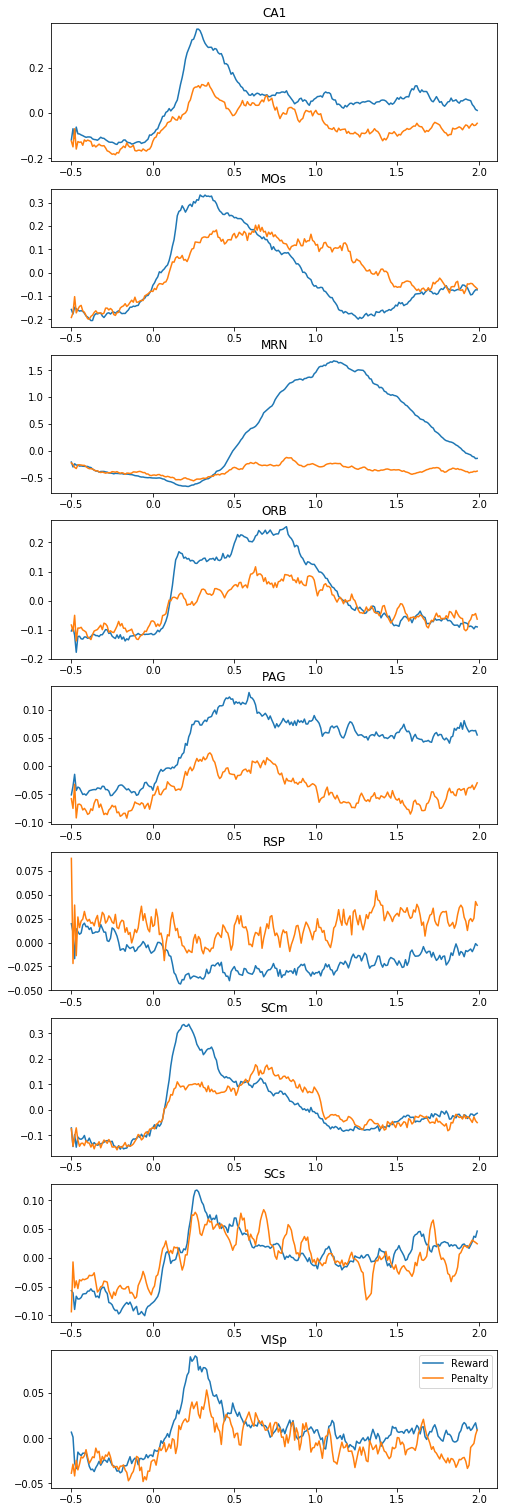

In [88]:
plt.figure(figsize=[8, 30])
# plot first component as a function of time
for i, brain_area in enumerate(brain_areas[:-1]):
    proj_data, explained_var = outcome_avg_pca(brain_area, n_components=1, moving_avg_window=5)
    
    reward_mean_trial = proj_data[:250]
    penalty_mean_trial = proj_data[250:]
    
    plt.subplot(len(brain_areas), 1, i+1)
    plt.plot(t, reward_mean_trial, label="Reward")
    plt.plot(t, penalty_mean_trial, label="Penalty")

    plt.title(brain_area)
plt.legend()
plt.show()

Explained var for  CA1 : [0.32014115 0.17610955]
Explained var for  MOs : [0.37569984 0.08365443]
Explained var for  MRN : [0.43490164 0.33556264]
Explained var for  ORB : [0.23508433 0.13895213]
Explained var for  PAG : [0.35019725 0.18051822]
Explained var for  RSP : [0.16214054 0.10738091]
Explained var for  SCm : [0.47289848 0.11123263]
Explained var for  SCs : [0.3249558  0.15639594]
Explained var for  VISp : [0.19200645 0.15276255]


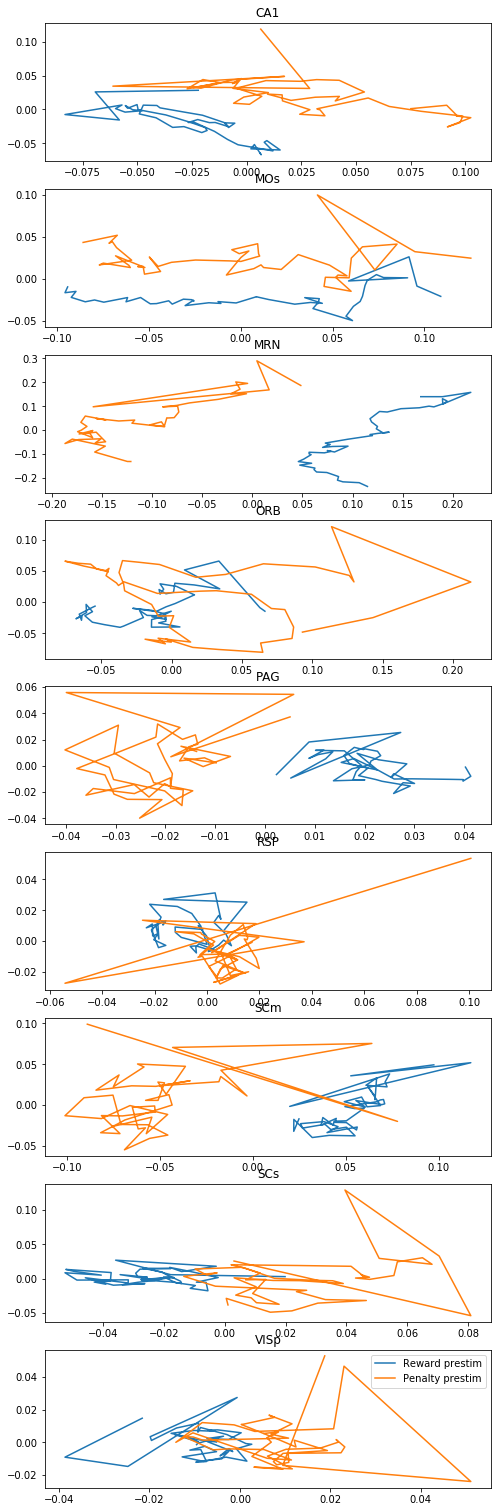

In [89]:
plt.figure(figsize=[8, 30])

# plot the two first principal components
brain_areas = np.unique(dat['brain_area'])
for i, brain_area in enumerate(brain_areas[:-1]):
    proj_data, explained_var = outcome_avg_pca(brain_area, moving_avg_window=5, n_timesteps=50)
    print("Explained var for ", brain_area, ":", explained_var)

    reward_mean_trial = proj_data[:50]
    penalty_mean_trial = proj_data[50:]

    plt.subplot(len(brain_areas), 1, i+1)
    plt.plot(reward_mean_trial[:,0], reward_mean_trial[:,1], label="Reward prestim")
    plt.plot(penalty_mean_trial[:,0], penalty_mean_trial[:,1], label="Penalty prestim")
    
    plt.title(brain_area)
plt.legend()
plt.show()



Explained var for  CA1 : [0.41100433 0.09848172]
Explained var for  MOs : [0.33698239 0.12745093]
Explained var for  MRN : [0.7720629 0.0756959]
Explained var for  ORB : [0.23466247 0.07396464]
Explained var for  PAG : [0.36645431 0.17834939]
Explained var for  RSP : [0.12813979 0.09984254]
Explained var for  SCm : [0.34134788 0.14534699]
Explained var for  SCs : [0.19787772 0.14236767]
Explained var for  VISp : [0.25542186 0.07795464]
Explained var for  root : [0.50171314 0.49828686]


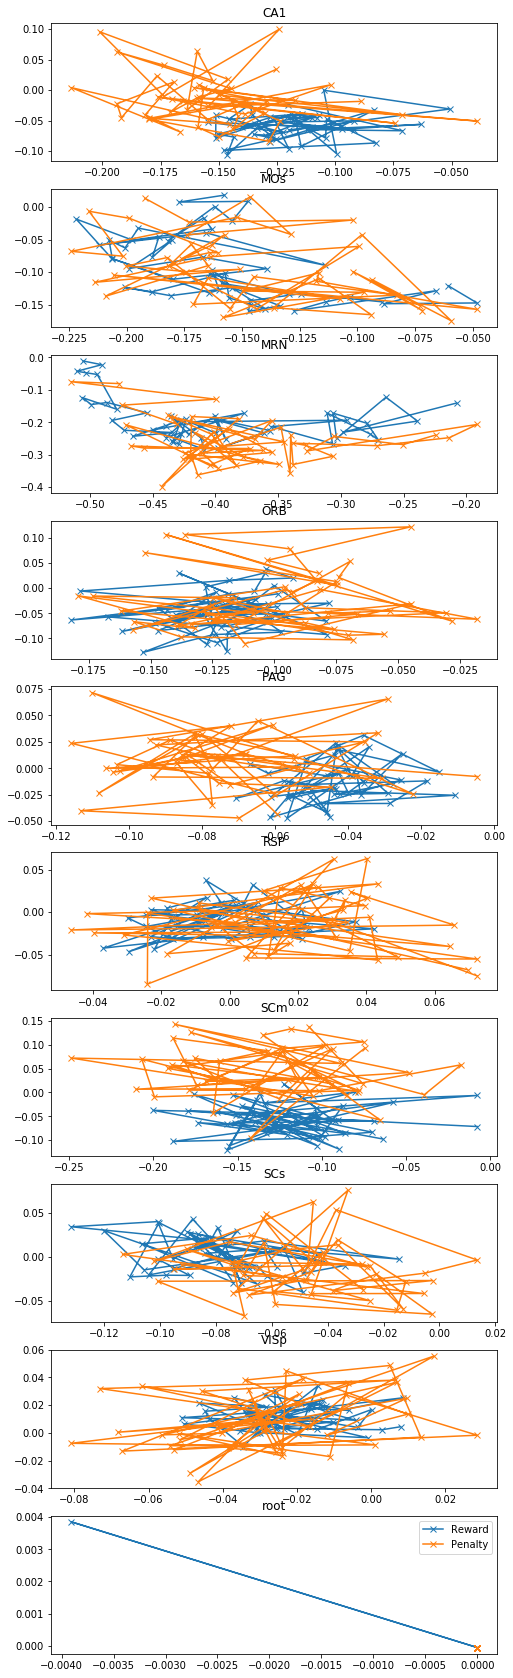

In [90]:
plt.figure(figsize=[8, 30])

brain_areas = np.unique(dat['brain_area'])
for i, brain_area in enumerate(brain_areas):
    proj_data, explained_var = outcome_avg_pca(brain_area, moving_avg_window=1)
    print("Explained var for ", brain_area, ":", explained_var)

    reward_mean_trial = proj_data[:250][:50]
    penalty_mean_trial = proj_data[250:][:50]

    plt.subplot(len(brain_areas), 1, i+1)
    plt.plot(reward_mean_trial[:,0], reward_mean_trial[:,1], label="Reward", marker="x")
    plt.plot(penalty_mean_trial[:,0], penalty_mean_trial[:,1], label="Penalty", marker="x")
    plt.title(brain_area)
plt.legend()
plt.show()

## Single-trial PCA

In [8]:
def single_trial_pca(brain_area, n_components=2, moving_avg_window=3, n_timesteps=250):
    spks = dat['spks'][dat['brain_area'] == brain_area]
    spks = spks[:,:,:n_timesteps]
    
    n_neurons, n_trials, _ = spks.shape
    
    # temporal smoothing
    for i in range(n_neurons):
        for j in range(n_trials):
            spks[i,j,(moving_avg_window-1):] = moving_average(spks[i,j], n=moving_avg_window)
    
    # n_trials*n_timesteps vectors of dimension n_neurons
    X = spks.reshape(n_neurons, n_trials*n_timesteps)
    X = X.T# n_samples = n_trials*n_timesteps x n_features = n_neurons
    
    # substract the mean firing rate for each neuron
    X = X - X.mean(axis=0)
#     X = z_score(X, True)
    
    pca = PCA(n_components=n_components)
    
    pca.fit(X)
    proj_X = pca.transform(X)
    proj_X = proj_X.T.reshape(n_trials, n_timesteps, n_components)
    return proj_X, pca.explained_variance_ratio_, pca.components_


Explained var for  CA1 : [0.11153906]
Explained var for  MOs : [0.08722197]
Explained var for  MRN : [0.22226998]
Explained var for  ORB : [0.07862381]
Explained var for  PAG : [0.20313557]
Explained var for  RSP : [0.10296895]
Explained var for  SCm : [0.13898569]
Explained var for  SCs : [0.13609344]
Explained var for  VISp : [0.19784048]


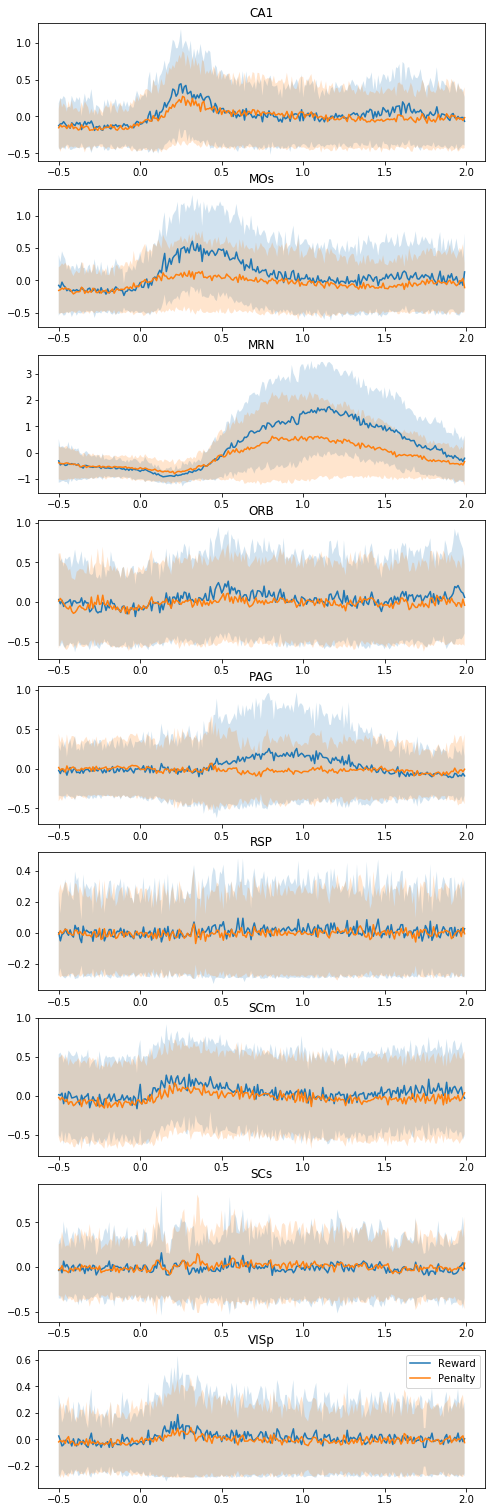

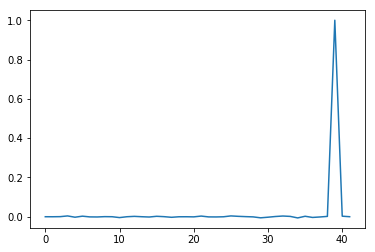

In [379]:
plt.figure(figsize=[8, 30])

# plot the two first principal components
brain_areas = np.unique(dat['brain_area'])

for i, brain_area in enumerate(brain_areas[:-1]):
    proj_data, explained_var, components = single_trial_pca(brain_area, moving_avg_window=1, n_components=1)
    print("Explained var for ", brain_area, ":", explained_var)
    
    
#     rew = proj_data[dat['feedback_type'] == 1][:,:,0]
#     pen = proj_data[dat['feedback_type'] == -1][:,:,0]

    rew = proj_data[dat['response'] == 1][:,:,0]
    pen = proj_data[dat['response'] != 1][:,:,0]
    
    # VISp stim gauche droite sur même session que pour HMM
    # stim onset, go cue
    
    plt.subplot(len(brain_areas), 1, i+1)
    
    plt.plot(t, rew.mean(0), label="Reward")
    plt.fill_between(t,rew.mean(0)-rew.std(0),rew.mean(0)+rew.std(0),alpha=.2)
    
    plt.plot(t, pen.mean(0), label="Penalty")
    plt.fill_between(t,pen.mean(0)-pen.std(0),pen.mean(0)+pen.std(0),alpha=.2)
    
    plt.title(brain_area)

plt.legend()
plt.show()


plt.plot(components[0])


Explained var for  CA1 : [0.09018412]
Explained var for  MOs : [0.05539392]
Explained var for  MRN : [0.10880101]
Explained var for  ORB : [0.07568036]
Explained var for  PAG : [0.2223837]
Explained var for  RSP : [0.09206327]
Explained var for  SCm : [0.14770224]
Explained var for  SCs : [0.17440655]
Explained var for  VISp : [0.15825795]


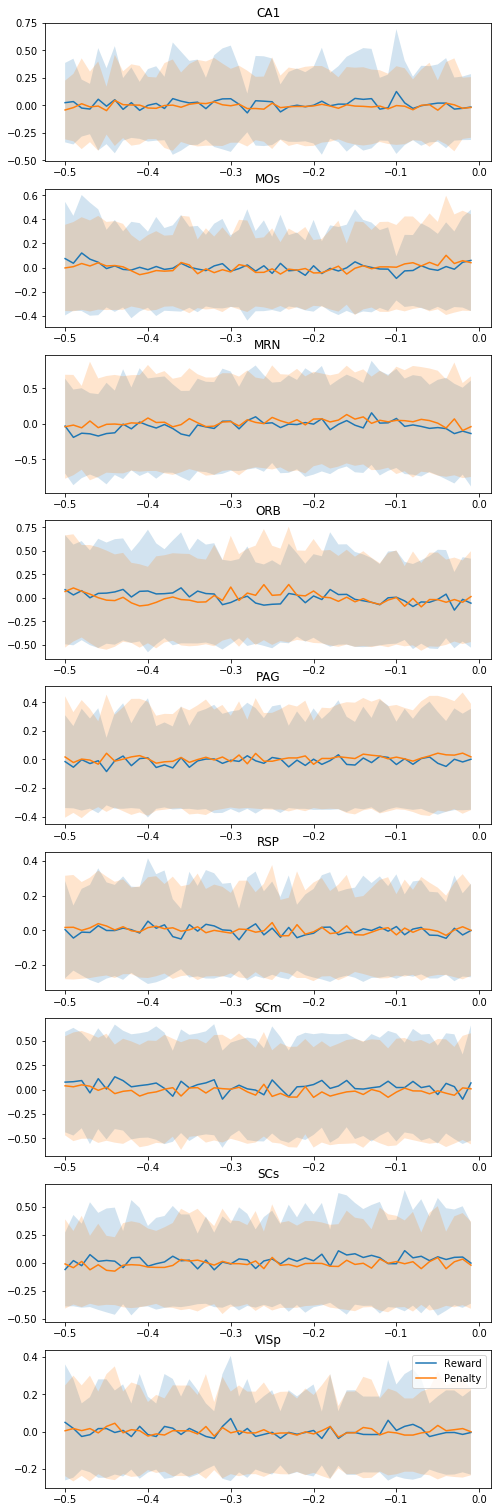

In [20]:
plt.figure(figsize=[8, 30])

# plot the two first principal components
brain_areas = np.unique(dat['brain_area'])

for i, brain_area in enumerate(brain_areas[:-1]):
    proj_data, explained_var, components = single_trial_pca(brain_area, moving_avg_window=1, n_components=1, n_timesteps=50)
    print("Explained var for ", brain_area, ":", explained_var)
    
    
#     rew = proj_data[dat['feedback_type'] == 1][:,:,0]
#     pen = proj_data[dat['feedback_type'] == -1][:,:,0]

    rew = proj_data[dat['response'] == 1][:,:,0]
    pen = proj_data[dat['response'] != 1][:,:,0]

    
    plt.subplot(len(brain_areas), 1, i+1)
    
    plt.plot(t[:50], rew.mean(0), label="Reward")
    plt.fill_between(t[:50],rew.mean(0)-rew.std(0),rew.mean(0)+rew.std(0),alpha=.2)
    
    plt.plot(t[:50], pen.mean(0), label="Penalty")
    plt.fill_between(t[:50],pen.mean(0)-pen.std(0),pen.mean(0)+pen.std(0),alpha=.2)
    
    plt.title(brain_area)

plt.legend()
plt.show()



# Functional Connectivity

## Spikes

In [123]:
print(dat['spks'].shape)

(756, 268, 250)


In [232]:
spks = dat['spks'][dat['brain_area'] == "MOs"]
# spks = dat['spks']
n_neurons = spks.shape[0]
n_trials = spks.shape[1]

# spks = spks[:,:,50:100]

moving_avg_window = 1000
for i in range(n_neurons):
    for j in range(n_trials):
        spks[i,j,(moving_avg_window-1):] = moving_average(spks[i,j], n=moving_avg_window)

reward_trials, penalty_trials = get_trials_by_outcome(dat)

reward_spks = spks[:,reward_trials]
penalty_spks = spks[:, penalty_trials]

print(reward_spks.shape, penalty_spks.shape)

idx = np.arange(reward_spks.shape[1])
np.random.shuffle(idx)
reward_spks = reward_spks[:,idx[:penalty_spks.shape[1]]]
print(reward_spks.shape, penalty_spks.shape)

reward_spks = reward_spks.reshape(n_neurons,-1)
penalty_spks = penalty_spks.reshape(n_neurons, -1)

print(reward_spks.shape)
reward_corr = np.corrcoef(reward_spks)
penalty_corr = np.corrcoef(penalty_spks)


(186, 181, 250) (186, 75, 250)
(186, 75, 250) (186, 75, 250)
(186, 18750)


c:\users\nathancloos\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\nathancloos\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


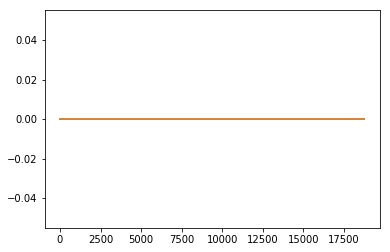

In [233]:
plt.plot(reward_spks[11])
plt.plot(penalty_spks[11])

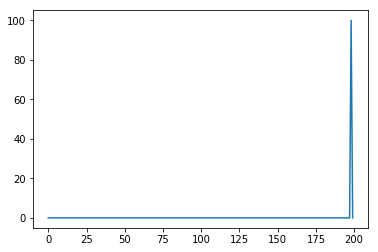

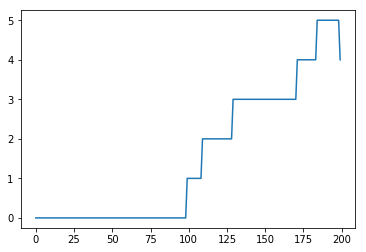

In [234]:
plt.plot(reward_spks[39][800:1000])
# plt.plot(reward_spks[3])
plt.show()


moving_avg_window = 100
i = 39
smooth_spks = moving_average(reward_spks[i], n=moving_avg_window)

plt.plot(smooth_spks[800:1000])
# plt.plot(reward_spks[3])
plt.show()

In [235]:
print(reward_corr)

[[ 1.00000000e+00  2.00397706e-02 -2.24776467e-03 ... -7.69263972e-03
   1.73760666e-02  1.30243180e-02]
 [ 2.00397706e-02  1.00000000e+00 -1.07564938e-02 ... -1.19145658e-02
  -5.38310158e-03 -1.15922241e-02]
 [-2.24776467e-03 -1.07564938e-02  1.00000000e+00 ... -1.77192417e-02
   1.27045301e-03  1.11973028e-02]
 ...
 [-7.69263972e-03 -1.19145658e-02 -1.77192417e-02 ...  1.00000000e+00
  -9.38816335e-03  1.71715688e-03]
 [ 1.73760666e-02 -5.38310158e-03  1.27045301e-03 ... -9.38816335e-03
   1.00000000e+00  6.75130964e-04]
 [ 1.30243180e-02 -1.15922241e-02  1.11973028e-02 ...  1.71715688e-03
   6.75130964e-04  1.00000000e+00]]


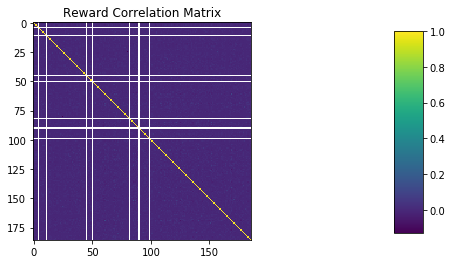

In [236]:
fig = plt.figure(figsize=(8, 4))
im = plt.imshow(reward_corr)
plt.title("Reward Correlation Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

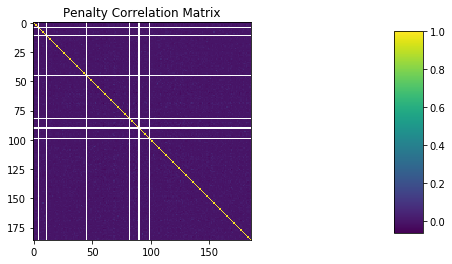

In [237]:
fig = plt.figure(figsize=(8, 4))
im = plt.imshow(penalty_corr)
plt.title("Penalty Correlation Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

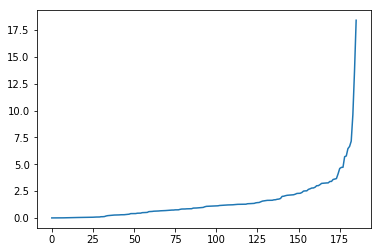

In [238]:
plt.plot(np.sort(spks.mean(axis=(1,2))))

No correlation among spikes because they are quite rare.

## LFP

In [368]:
def corr_lfp(start, stop, condition_on="outcome"):
    lfp = dat['lfp']
    lfp = lfp[:,:,start:stop]

    n_areas = lfp.shape[0]
    n_trials = spks.shape[1]
    
    if condition_on == "outcome":
        reward_trials, penalty_trials = get_trials_by_outcome(dat)

        reward_lfp = lfp[:,reward_trials]
        penalty_lfp = lfp[:, penalty_trials]
    elif condition_on == "response":
        reward_lfp = lfp[:,dat['response'] != 0]
        penalty_lfp = lfp[:,dat['response'] == 0]
    else:
        raise Exception("Cannot condition on {}".format(condition_on))

#     idx = np.arange(reward_lfp.shape[1])
#     np.random.shuffle(idx)
#     reward_lfp = reward_lfp[:,idx[:penalty_lfp.shape[1]]]

    reward_lfp = reward_lfp.reshape(n_areas,-1)
    penalty_lfp = penalty_lfp.reshape(n_areas, -1)

    reward_corr = np.corrcoef(reward_lfp)
    penalty_corr = np.corrcoef(penalty_lfp)
    
    return reward_corr, penalty_corr

def plot_corr_lfp(reward_corr, penalty_corr):
    fig = plt.figure(figsize=(8, 4))
    im = plt.imshow(reward_corr)
    plt.title("Reward Correlation Matrix")

    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.show()

    fig = plt.figure(figsize=(8, 4))
    im = plt.imshow(penalty_corr)
    plt.title("Penalty Correlation Matrix")

    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()

In [369]:
print(dat['brain_area_lfp'])

['DG', 'LGd', 'SUB', 'VISp', 'ACA', 'MOs', 'PL', 'CA1', 'DG', 'LH', 'MD', 'VISam']


### Prestimulus functional connectivity

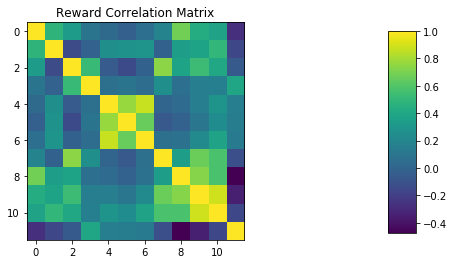

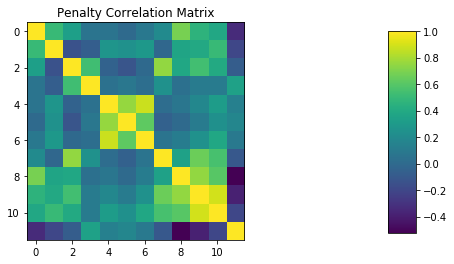

Mean corr: reward 0.2889264662272506 penalty 0.28527819342462724


In [371]:
reward_corr, penalty_corr = corr_lfp(0, 50, condition_on="outcome")
plot_corr_lfp(reward_corr, penalty_corr)

print("Mean corr:", "reward", np.mean(reward_corr), "penalty", np.mean(penalty_corr))

### Stimulus onset functional connectivity

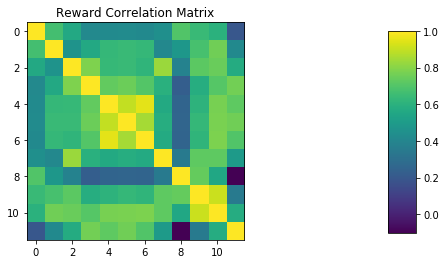

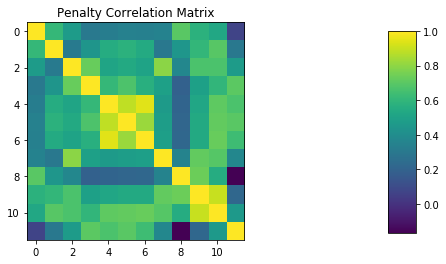

Mean corr: reward 0.6280966139346614 penalty 0.5622180505690557


In [372]:
reward_corr, penalty_corr = corr_lfp(50, 100)
plot_corr_lfp(reward_corr, penalty_corr)

print("Mean corr:", "reward", np.mean(reward_corr), "penalty", np.mean(penalty_corr))
# look at the abs diff between reward and penalty


### Stimulus onset functional connectivity conditionned on response

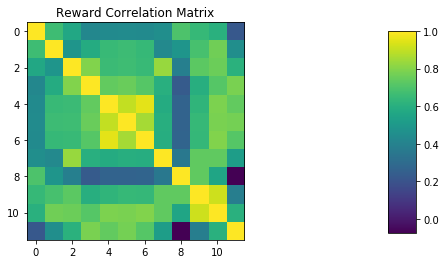

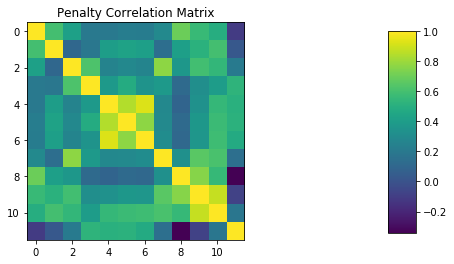

Mean corr: left/right 0.6397277234538871 nogo 0.44105217736343794


In [374]:
reward_corr, penalty_corr = corr_lfp(50, 100, condition_on="response")
plot_corr_lfp(reward_corr, penalty_corr)

print("Mean corr:", "left/right", np.mean(reward_corr), "nogo", np.mean(penalty_corr))

Seems more difficult to predict performance than engagement/movement.